In [12]:
from Bio import pairwise2
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import os
import pandas as pd
def aligned(ref_seq,query_seq):
    # Define the gap penalty

    ref_seq = Seq(ref_seq.upper())
    query_seq = Seq(query_seq.upper())
    # Perform global sequence alignment with custom gap penalty
    # 0.5 points are deducted when opening a gap, and 0.1 points are
    alignments = pairwise2.align.globalms(ref_seq, query_seq, 3, -1, -5, -0.1)
    #print(alignments)
    query_aligned = alignments[0][1]
    ref_aligned = alignments[0][0]
    return query_aligned, ref_aligned



def short_DNA_align(seq1,seq2):
    # Define the scoring parameters
    match_score = 1
    mismatch_penalty = -1
    gap_open_penalty = -2
    gap_extension_penalty = -1

    # Perform the pairwise alignment using globalds function
    alignments = pairwise2.align.globalms(seq1, seq2, match_score, mismatch_penalty, gap_open_penalty, gap_extension_penalty)

    # Extract the first (and only) alignment from the list of alignments
    alignment = alignments[0]

    # Calculate the number of gaps and mismatches in the alignment
    num_gaps = alignment[0].count("-")+alignment[1].count("-")
    num_mismatches = sum(1 for a, b in zip(*alignment[:2]) if a != b and a != "-" and b != "-")

    # Calculate the total number of gaps and mismatches
    total_errors = num_gaps + num_mismatches

    # Print the alignment and the total number of gaps and mismatches
    return total_errors

In [13]:
def combine_insertions(insertions):
    """
    This function takes in a list of insertion information as tuples, where the first value in each tuple is the position
    and the second value is the DNA base. It combines adjacent insertions at the same position and returns a new list of tuples,
    where the first value is the position of the insertion and the second value is a string representing the combined bases.
    """
    combined = []
    current_pos = None
    current_bases = ''
    for pos, base in insertions:
        if current_pos is None:
            current_pos = pos
            current_bases = base
        elif pos == current_pos + len(current_bases):
            current_bases += base
        else:
            combined.append((current_pos, current_bases))
            current_pos = pos
            current_bases = base
    combined.append((current_pos, current_bases))
    return combined

def insertion_deletion_position(alignment_len,insertion,deletion):
    insertion_fixed = []
    deletion_fixed = []
    fix_index = 0
    for num in range(alignment_len):
        if len(insertion) >=1:
            if insertion[0][0] == num:
                insertion_fixed.append((insertion[0][0]+fix_index, insertion[0][1]))
                fix_index -= len(insertion[0][1])
                
                insertion = insertion[1:]
                
            
        if len(deletion) >=1:    
            if deletion[0][0] == num:
                deletion_fixed.append((deletion[0][0]+fix_index,deletion[0][1]))
                deletion = deletion[1:]
            
        else:
            pass
    return insertion_fixed, deletion_fixed
        
    

def alignment_prase(ref_seq,query_seq):
    # remove gaps at the start or end of the sequences
    alignment_len = len(ref_seq)
    removed = 0
    while ref_seq.startswith("-"):

        ref_seq = ref_seq[1:]
        query_seq = query_seq[1:]
        
    while query_seq.startswith("-"):
        removed = removed + 1
        ref_seq = ref_seq[1:]
        query_seq = query_seq[1:]        
    while ref_seq.endswith("-") or query_seq.endswith("-"):
        ref_seq = ref_seq[:-1]
        query_seq = query_seq[:-1]
    # initialize variables for tracking insertion, deletion, and mismatch counts
    insertion_count = 0
    deletion_count = 0
    mismatch_count = 0
    insertion = []
    deletion = []
    mismatch = []
    # iterate over each position in the sequences
    
    for i in range(len(ref_seq)):
        if ref_seq[i] == query_seq[i]:
            # the bases match, do nothing
            pass
        elif query_seq[i] == "-":
            # this is a deletion in the query sequence
            
            deletion_tuple = (i+removed+1,ref_seq[i])
            deletion.append(deletion_tuple)
            deletion_count += 1
        elif ref_seq[i] == "-":
            # this is an insertion in the query sequence
            
            insertion_tuple = (i+removed+1,query_seq[i])
            insertion.append(insertion_tuple)
            insertion_count += 1
        else:
            # this is a substitution
            mismatch_count += 1
            mismatch_tuple = (i+removed-insertion_count+1,ref_seq[i],query_seq[i])
            
            mismatch.append(mismatch_tuple)
    #print(insertion)
    insertion = combine_insertions(insertion)
    deletion = combine_insertions(deletion)
    insertion_fix, deletion_fix = insertion_deletion_position(alignment_len,insertion,deletion)
    return deletion_fix, insertion_fix,mismatch

In [14]:
def get_expect(df,expect_seq):
    no_gaps_ref = df['Reference_Sequence'][0].replace("-", "")
    expext_aligned, ref_aligned = aligned(no_gaps_ref,expect_seq)
    #print( expext_aligned, ref_aligned )
    deletion, insertion,mismatch = main(ref_aligned,expext_aligned)
    return deletion, insertion,mismatch
def dict_change (dict_,name, value):
    if name not in dict_:
        dict_[name]= value
    else:
        dict_[name] += value
    return dict_
def insertion_check (insertion ,insertion_exp ,mismath_gap_allow):
    for tup in insertion:
        error_ins = short_DNA_align(tup[1],insertion_exp[0][1])
        if error_ins < mismath_gap_allow:
            return True
            break
    return False

def read_fasta(file_path):
    sequences = {}
    with open(file_path, 'r') as fasta_file:
        sequence_id = None
        sequence = ''
        for line in fasta_file:
            line = line.strip()
            if line.startswith('>'):
                if sequence_id:
                    sequences[sequence_id] = sequence
                sequence_id = line[1:]
                sequence = ''
            else:
                sequence += line
        if sequence_id:
            sequences[sequence_id] = sequence
    return sequences


def search_files(directory):
    lst = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            lst.append(file_path)
    return lst

In [15]:
def classify_data(df_alleles,Locus,exp_dict):
    dict_classified = {'unmodified': 0,'deletion_only': 0,'unrelated_insertion': 0,'perfect_editing': 0, 'mismatch_only': 0,
         'perfect_insertion_with_mismatch': 0, 'deletion_and_mismatch': 0,'imperfect_insertion': 0,
          'perfect_insertion_with_deletion': 0,'perfect_insertion_with_deletion_and_mismatch':0}
    deletion_exp, insertion_exp,mismatch_exp =exp_dict[Locus]
    for num in range(len(df_alleles)):
        deletion, insertion, mismatch = alignment_prase(df_alleles['Reference_Sequence'][num],df_alleles['Aligned_Sequence'][num])
        if deletion == [] and insertion == [] and mismatch == []:
            dict_classified = dict_change(dict_classified,'unmodified', df_alleles['%Reads'][num])

        elif len(insertion) != 0:
            if insertion == insertion_exp:
                if deletion == deletion_exp and mismatch == mismatch_exp:
                    dict_classified = dict_change(dict_classified,'perfect_editing', df_alleles['%Reads'][num])
                elif deletion == deletion_exp:
                    dict_classified = dict_change(dict_classified,'perfect_insertion_with_mismatch', df_alleles['%Reads'][num])
                elif mismatch == mismatch_exp:
                    dict_classified = dict_change(dict_classified,'perfect_insertion_with_deletion', df_alleles['%Reads'][num])
                else:
                    dict_classified = dict_change(dict_classified,'perfect_insertion_with_deletion_and_mismatch', df_alleles['%Reads'][num])
            elif all(tup in insertion_exp for tup in insertion):
                dict_classified = dict_change(dict_classified,'perfect_insertion_with_insertion', df_alleles['%Reads'][num])
            else:
                if insertion_check(insertion ,insertion_exp ,mismath_gap_allow) == True:
                    dict_classified = dict_change(dict_classified,'imperfect_insertion', df_alleles['%Reads'][num])
                else:    
                    dict_classified = dict_change(dict_classified,'unrelated_insertion', df_alleles['%Reads'][num])
        elif len(deletion) != 0:
            if len(mismatch) == 0:
                dict_classified = dict_change(dict_classified,'deletion_only', df_alleles['%Reads'][num])
            else:
                dict_classified = dict_change(dict_classified,'deletion_and_mismatch', df_alleles['%Reads'][num])
        else:
            dict_classified = dict_change(dict_classified,'mismatch_only', df_alleles['%Reads'][num])


            pass
    # Define the data as a dictionary

    return dict_classified

In [16]:
def ploting_pie_chart(dict_classified,out_name):
    labels = list(dict_classified.keys())
    values = list(dict_classified.values())
    colors_dic = {'unmodified':"#0074D9", 'perfect_editing': "#2ECC40", 'deletion_only':"#FFDC00",
              'imperfect_insertion':"#0000FF",'unrelated_insertion':"#FF4136",'mismatch_only':"#FF851B",
              'deletion_and_mismatch':"#00FF00",'perfect_insertion_with_deletion':"#B10DC9", 'perfect_insertion_with_mismatch':"#FF0000",
             'perfect_insertion_with_deletion_and_mismatch':"#AAAAAA"}

    colors = []
    for name in labels:
        colors.append(colors_dic[name])

    # Create the pie chart
    plt.pie(values, labels=labels, colors=colors,autopct="%1.1f%%")

    # Add a title to the chart
    #plt.title("RFP_cas9+NRT49")

    # Show the chart
    plt.savefig(out_name)
    plt.show()
    plt.close() 

In [17]:
mismath_gap_allow = 3
file_path = './ref/retron_reference.fasta'
fasta_sequences = read_fasta(file_path)
directory_path = './table'
path_lst = search_files(directory_path)
exp_dict = {'HBB':[[],[(87, 'AGCATGTAGC')],[]] ,'F9':[[],[(119, 'GCATGTAGCA')] ,[]],'EMX1':[[],[(121, 'AGCATGTAGC')],[]],'CFTR':[[], [(119, 'AGCATGTAGC')],[]]}

In [18]:
#check for plot 1
df_alleles = pd.read_csv('./table/CRISPResso_on_NGS-9_R1_NGS-9_R2_table.txt',sep='\t')
#
for num in range(10):
    deletion, insertion, mismatch = alignment_prase(df_alleles['Reference_Sequence'][num],df_alleles['Aligned_Sequence'][num])
    print ('deletion:'+str(deletion),'insertion:'+str(insertion), 'mismatch:'+str(mismatch))

deletion:[] insertion:[] mismatch:[]
deletion:[] insertion:[(121, 'AGCATGTAGC')] mismatch:[]
deletion:[] insertion:[(121, 'A')] mismatch:[]
deletion:[(122, 'AAG')] insertion:[] mismatch:[]
deletion:[(119, 'AAGAAG')] insertion:[] mismatch:[]
deletion:[(120, 'A')] insertion:[] mismatch:[]
deletion:[] insertion:[] mismatch:[(87, 'T', 'G')]
deletion:[(113, 'CAGAAGAAG')] insertion:[] mismatch:[]
deletion:[(110, 'GAGCAGAAGAAGAAGGGCTCC')] insertion:[] mismatch:[]
deletion:[(121, 'G')] insertion:[] mismatch:[]


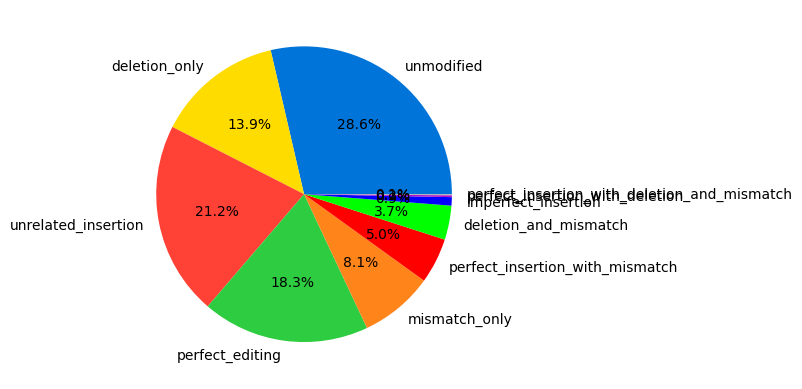

In [20]:
dict_classified = classify_data(df_alleles,'EMX1',exp_dict)
ploting_pie_chart(dict_classified,'./out/EMX1_test.pdf')